# 数据预处理
将赛方提供的数据处理成为 word/tag 的数据形式。

### 多词视角问题：
在给出的语料中，有很多视角并不是单个词的形式出现的。为了解决这个问题，我们将视角分成按照单词和多词的不同类型进行标注。

- o: 非视角词  
- s: 单词视角
- b: 视角首词
- m: 视角中词
- e: 视角尾词
- x: 填充 tag

把每个词看作一个字符的话，那么每个视角现在就是一个字符串。我们需要根据 Label.csv 提供的结果来把 Train.csv 中的数据转为 word/tag 这种形式的话，相当于在**字符串（句子）中寻找子串（视角）**，并返回子串的位置。这样我们就可以根据子串的长度来给对应位置上的tag赋值。

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import jieba 
import pickle

KMP 算法实现子串查找。参考：[字符串匹配的KMP算法](http://www.ruanyifeng.com/blog/2013/05/Knuth%E2%80%93Morris%E2%80%93Pratt_algorithm.html)

In [2]:
def match_len(ss):
    """获取ss"前缀"和"后缀"的最长的共有元素的长度。"""
    for i in xrange(1,len(ss)):
        if ss[:-i] == ss[i:]:
            return len(ss[i:])
    return 0

def create_map(str_sub):
    """构建部分匹配表。"""
    str_len = len(str_sub)
    match_map = [0] * str_len
    for i in xrange(str_len):
        match_map[i] = match_len(str_sub[:i+1])
    return match_map
    
    
def KMP(list_p, list_sub):
    """在字符串 list_p 中查找 list_sub, 并返回所有出现的位置。
    @list_p: 长度为 n 的字符串。以 list 形式存储。
    @list_sub: 长度为 m 的字符串。 以 list 形式存储。
    return：
    @locs: list,记录 str_sub 在str_p 出现的每个位置（首字符的下标）。
    """
    # 构建部分匹配表，用 match_lens 来存储。
    match_map = create_map(list_sub)
    locs = list()
    n = len(list_p)
    m = len(list_sub)
    start = 0         # 首字母匹配位置
    match_count = 0   # 目前已经匹配的长度
    while start <= n-m:  
        if match_count == m:  # 若完全匹配
            locs.append(start)   # 将当前起始位置返回
            start += (m - match_map[m-1])  # 跳越并继续查找
            match_count = 0
        elif list_p[start+match_count] == list_sub[match_count]:     # 如果当前字符匹配正确
            match_count += 1
        elif match_count < 2:  # 否则，目前字符匹配不上,跳转
            start += 1
            match_count = 0
        else:
            start += (match_count-match_map[match_count-1])
            match_count = 0
    return locs

In [3]:
# 例1  
str_p = 'BBC ABCDAB ABCDABCDABDE'
str_sub = 'ABCDABD'
locs = KMP(str_p, str_sub)
print locs

# 例2
str_p = 'BBC ABCDAB ABCDABCDABDE'
str_sub = 'A'
locs = KMP(str_p, str_sub)
print locs

[15]
[4, 8, 11, 15, 19]


### 利用 Label.csv 的结果对 Train.csv 的数据进行标注

In [4]:
def get_label(tags, locs, view_len):
    """根据 view_len 给每个词打上 tag."""
    if view_len == 1:
        for loc in locs:
            tags[loc] = 's'
        return tags
    if view_len == 2:
        for loc in locs:
            tags[loc] = 'b'
            tags[loc+1] = 'e'
        return tags
    for loc in locs:
        start = loc
        end = loc + view_len - 1
        tags[start] = 'b'
        tags[end] = 'e'
        tags[start+1:end] = ['m'] * (view_len-2)
    return tags

def get_tag(SentenceId):
    """对每个句子，给每个 word 打上对应的标签。"""
    words  = sr_id2words[SentenceId]
    tags = ['o'] * len(words)
    if not dict_id2views.has_key(SentenceId): # 说明没有视角
        return tags
    views = dict_id2views[SentenceId]
    for view in views:
        locs = KMP(words, view)
        if len(locs) == 0:
            miss_id.append(SentenceId)
            miss_view.append(view)
#             print 'Error match %d ' % SentenceId
        tags = get_label(tags, locs, len(view))
    return tags

In [5]:
df_Train = pd.read_csv('../raw_data/Train.csv', sep='\t')
df_Label = pd.read_csv('../raw_data/Label.csv', sep='\t')
df_Train['words'] = df_Train.Content.apply(lambda ss: list(jieba.cut(ss)))
df_Label['words'] = df_Label.View.apply(lambda ss: list(jieba.cut(ss)))
print df_Train.head(2)
print df_Label.head(2)

# 建立 id:views 对应的列表
grouped = df_Label.groupby('SentenceId')
# 按照 'SentenceId' 这列分组了，name 为 'SentenceId' 的 key 值，group 为对应的df_group
dict_id2views = dict()
for SentenceId, group in grouped:
    views = group.words.values
    dict_id2views[SentenceId] = views
sr_id2words = pd.Series(df_Train.words.values, index=df_Train.SentenceId.values)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.287 seconds.
Prefix dict has been built succesfully.


   SentenceId                                            Content  \
0       28171  测试的主角---全新速派TSI330智行版测试的主角---全新速派TSI330智行版测试的主...   
1       28169  而高尔夫GTI、新速腾GLI和新速腾R-Line这些产品家族中极具动感的车型，也在赛场之外将...   

                                               words  
0  [测试, 的, 主角, -, -, -, 全新, 速派, TSI330, 智行, 版, 测试...  
1  [而, 高尔夫, GTI, 、, 新速腾, GLI, 和, 新速腾, R, -, Line,...  
   SentenceId View Opinion  words
0       28171   速派     pos   [速派]
1       28171  斯柯达     pos  [斯柯达]


In [6]:
miss_id = list()  # 记录分词错误导致无法匹配的view (id)
miss_view = list() 
%time df_Train['tags'] = df_Train.SentenceId.apply(get_tag)

print 'all view num = %d; miss view num = %d; missing rate = %1.2f' % \
       (len(df_Label), len(miss_view), float(len(miss_view)) / len(df_Label))   # 共有 781 个view 没有找到

for i in xrange(len(miss_id)):
    sentence_id = miss_id[i]
#     print 'ID=%s \n%s\n' % (sentence_id, ' / '.join(miss_view[i]))
#     print ' / '.join(sr_id2words[sentence_id])
#     print '-' * 10

CPU times: user 296 ms, sys: 12 ms, total: 308 ms
Wall time: 305 ms
all view num = 10977; miss view num = 781; missing rate = 0.07


从上面的结果来分析，大概有 0.07 的视角由于分词的问题导致最后无法正确切分。原因有很多，比如：

*新速腾* 结果标注为 *速腾*

*/ 捷豹 / 路 / 虎 / *居然连路虎都给分词错误

*林肯车 / 型 / *这样的分词错误也是无解了
 
 不过整体来说， 0.07 的错误暂时还能接受。因为不需要刷分数，所以先把这个问题留着，影响不大。

### 处理 LabelSecond.csv 的结果对 TrainSecond.csv 的数据进行标注

In [7]:
df_TrainSecond = pd.read_csv('../raw_data/TrainSecond.csv', sep='\t')
df_LabelSecond = pd.read_csv('../raw_data/LabelSecond.csv', sep='\t')
df_TrainSecond['words'] = df_TrainSecond.Content.apply(lambda ss: list(jieba.cut(ss)))
df_LabelSecond['words'] = df_LabelSecond.View.apply(lambda ss: list(jieba.cut(ss)))
print df_TrainSecond.head(2)
print df_LabelSecond.head(2)

# 建立 id:views 对应的列表
grouped = df_LabelSecond.groupby('SentenceId')
# 按照 'SentenceId' 这列分组了，name 为 'SentenceId' 的 key 值，group 为对应的df_group
dict_id2views = dict()
for SentenceId, group in grouped:
    views = group.words.values
    dict_id2views[SentenceId] = views
sr_id2words = pd.Series(df_TrainSecond.words.values, index=df_TrainSecond.SentenceId.values)

  SentenceId                       Content  \
0     S30000  天籁公爵——加长版礼宾座驾，以公爵之礼遇，开启专属之享。   
1     S30001        比众泰更早一步，江淮版兰博基尼，10万可带走   

                                               words  
0  [天籁, 公爵, —, —, 加长版, 礼宾, 座, 驾, ，, 以, 公爵, 之, 礼遇,...  
1   [比众, 泰, 更, 早, 一步, ，, 江淮, 版, 兰博基尼, ，, 10, 万可, 带走]  
  SentenceId  View Opinion     words
0     S30000  天籁公爵     neu  [天籁, 公爵]
1     S30001    众泰     neu      [众泰]


In [8]:
miss_id = list()  # 记录分词错误导致无法匹配的view (id)
miss_view = list() 
%time df_TrainSecond['tags'] = df_TrainSecond.SentenceId.apply(get_tag)

print 'all view num = %d; miss view num = %d; missing rate = %1.2f' % \
       (len(df_Label), len(miss_view), float(len(miss_view)) / len(df_Label))   # 共有 781 个view 没有找到

for i in xrange(len(miss_id)):
    sentence_id = miss_id[i]
#     print 'ID=%s \n%s\n' % (sentence_id, ' / '.join(miss_view[i]))
#     print ' / '.join(sr_id2words[sentence_id])
#     print '-' * 10

CPU times: user 232 ms, sys: 4 ms, total: 236 ms
Wall time: 232 ms
all view num = 10977; miss view num = 900; missing rate = 0.08


### 标上 tag 的结果

In [9]:
df_train = pd.concat([df_Train.loc[:, ['SentenceId', 'words', 'tags']],df_TrainSecond.loc[:, ['SentenceId', 'words', 'tags']]])
df_train.head(2)

,SentenceId,words,tags
0,28171,"[测试, 的, 主角, -, -, -, 全新, 速派, TSI330, 智行, 版, 测试...","[o, o, o, o, o, o, o, s, o, o, o, o, o, o, o, ..."
1,28169,"[而, 高尔夫, GTI, 、, 新速腾, GLI, 和, 新速腾, R, -, Line,...","[o, b, e, o, o, o, o, o, o, o, o, o, o, o, o, ..."


In [10]:
df_label = pd.concat([df_Label, df_LabelSecond])
df_label.describe()

,SentenceId,View,Opinion,words
count,20591,20591,20591,20591
unique,14426,3030,3,3030
top,S36315,大众,neu,[大众]
freq,21,711,14293,711


### 分词后句子的词数量分布

max_num=930, min_num=2, mean_num=27


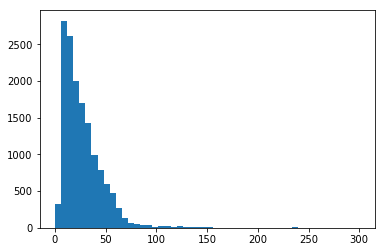

In [11]:
df_train['words_num'] = df_train.words.apply(lambda words: len(words))
words_num = df_train.words_num.values
max_num = max(words_num)
min_num = min(words_num)
mean_num = np.mean(words_num)
print 'max_num=%d, min_num=%d, mean_num=%d' % (max_num, min_num, mean_num)
plt.hist(df_train.words_num, range=(0,300), bins=50)
plt.show()

### 序列补全和切割

为了便于训练，按照下面的方式来对句子进行补全或者切分。

- 取 max_len = 32
- 若句子长度小于 max_len, words 用 'UNKNOWN'， tags用 'x'填充
- 若句子长度长于 max_len, 则按照 max_len 长度进行切分。最后一段不足 max_len 补全。

In [12]:
max_len = 32

In [13]:
# 把 words 和 tags 按照 max_len 的长度进行切分
def chunks(plist, n, pad_symbol):
    """cut successive n-size chunks from plist."""
    sub_lists = list()
    for i in xrange(0, len(plist), n):
        sub_lists.append(plist[i:i+n])
    if len(sub_lists[-1]) < n: # 对不足 n 的序列填充
        sub_lists[-1].extend([pad_symbol] * (n-len(sub_lists[-1])))
    return sub_lists

In [14]:
df_train['chunk_words'] = df_train.words.apply(chunks, n=max_len, pad_symbol='UNKNOWN')
df_train['chunk_tags'] = df_train.tags.apply(chunks, n=max_len, pad_symbol='x')

In [15]:
df_train.head(2)

,SentenceId,words,tags,words_num,chunk_words,chunk_tags
0,28171,"[测试, 的, 主角, -, -, -, 全新, 速派, TSI330, 智行, 版, 测试...","[o, o, o, o, o, o, o, s, o, o, o, o, o, o, o, ...",237,"[[测试, 的, 主角, -, -, -, 全新, 速派, TSI330, 智行, 版, 测...","[[o, o, o, o, o, o, o, s, o, o, o, o, o, o, o,..."
1,28169,"[而, 高尔夫, GTI, 、, 新速腾, GLI, 和, 新速腾, R, -, Line,...","[o, b, e, o, o, o, o, o, o, o, o, o, o, o, o, ...",47,"[[而, 高尔夫, GTI, 、, 新速腾, GLI, 和, 新速腾, R, -, Line...","[[o, b, e, o, o, o, o, o, o, o, o, o, o, o, o,..."


In [16]:
del df_Train, df_Label, df_TrainSecond, df_LabelSecond

## 将 words 和 tags 转为 id 的形式

In [17]:
# 对于 填充用的 UNKNOWN 符号，用 。词向量表示先
with open('../data/embedding_data.pkl', 'rb') as inp:
    W_embedding = pickle.load(inp)
    sr_id2word = pickle.load(inp)
    sr_word2id = pickle.load(inp)

_tags = ['o', 's', 'b', 'm', 'e', 'x']
tag_ids = range(len(_tags))
sr_tag2id = pd.Series(tag_ids, index=_tags)
sr_id2tag = pd.Series(_tags, index=tag_ids)

In [18]:
sr_tag2id

o    0
s    1
b    2
m    3
e    4
x    5
dtype: int64

In [19]:
from itertools import chain

words = list(chain(*df_train.chunk_words.values))
words = np.asarray(words).flatten()
id4words = sr_word2id[words].values
# id4words = id4words.reshape([-1, max_len])
tags = list(chain(*df_train.chunk_tags.values))
tags = np.asarray(tags).flatten()
id4tags = sr_tag2id[tags].values

X = id4words.reshape([-1, max_len])
y = id4tags.reshape([-1, max_len])

print X.shape, y.shape

(19739, 32) (19739, 32)


In [20]:
# 数据展示, X 中出现了一些 nan 值
num = 1
print X[num]
print y[num]
print ' / '.join(words[num*max_len:(num+1)*max_len])

[   75   287  3768    12    12   110  1118   928  1511  6113   474    32
  5054 23257    92     0  2229 39238  3932     0 17201  1171  7092   328
    19     0   229 29167  7507  3898   474    32]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
版 / 斯柯达 / 标 / - / - / 这个 / 角度 / 看上去 / 是不是 / 很帅 / 前大灯 / 采用 / 三角 / 折面 / 造型 / ， / 立体 / 晶璨 / 切割 / ， / 黑底 / 银色 / 悬浮 / 线条 / 设计 / ， / 打造 / 多型面 / 几何 / 层次 / 前大灯 / 采用


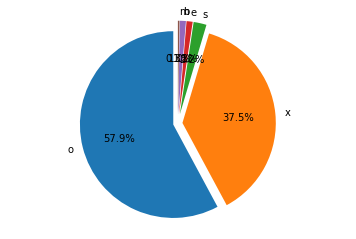

In [22]:
# 统计 tag 的类型分布
tags_count = pd.Series(tags).value_counts()
labels = tags_count.index
sizes = tags_count.values
fig1, ax1 = plt.subplots()
explode = (0.05, 0.05, 0.1, 0.1, 0.1, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

在所有的 tags 类型中，仅非实体词（o）和填充词（x）两类就一共占了 95.4%.所以类别比例非常不均衡。而且在四个小类别中，m 类占的比例更是非常小。而且，在训练语料中，按照 max_len 切分和填充以后，一共也仅有 19739 个句子（片段）。所以在小样本，类别不均衡的情况下实现准确的实体识别还是有相当大的难度。

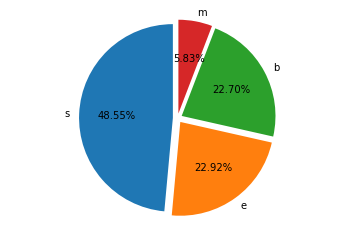

In [23]:
#  上面四部分太小了，看不清
labels = tags_count.index[-4:]
sizes = tags_count.values[-4:]
fig1, ax1 = plt.subplots()
explode = (0.05, 0.05,0.05, 0.05)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [24]:
"""
保存数据，在模型训练是直接导入即可。
X: shape = [sample_number, max_len], 每个元素为一个 word 对应的 id
y: shape = [sample_number, max_len]，每个元素为一个 tag 对应的 id
"""

with open('../data/dataset.pkl', 'wb') as outp:
    %time pickle.dump(X, outp)
    %time pickle.dump(y,outp)

CPU times: user 560 ms, sys: 16 ms, total: 576 ms
Wall time: 577 ms
CPU times: user 456 ms, sys: 12 ms, total: 468 ms
Wall time: 468 ms
